In [1]:
# set conda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# install psi4
!conda install -y psi4 python=3.7 -c psi4

# set path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

--2022-04-20 10:25:20--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-04-20 10:25:20--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75660608 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  72.16M   288MB/s    in 0.3s    

2022-04-20 10:25:21 (288 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
# import Psi4
import psi4
# check Psi4 version
print(psi4.__version__)

1.5


In [28]:
!pip install distributed

     |████████████████████████████████| 837 kB 28.0 MB/s 
     |████████████████████████████████| 96 kB 5.7 MB/s 
     |████████████████████████████████| 132 kB 47.1 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.7 MB/s 
     |████████████████████████████████| 428 kB 40.5 MB/s 
     |████████████████████████████████| 299 kB 45.1 MB/s 
     |████████████████████████████████| 136 kB 55.6 MB/s 


In [38]:
import numpy as np

from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from psi4.driver.p4util import spectrum

psi4.core.set_output_file("moxy.out")

moxy = psi4.geometry("""0 1
C  0.152133 -0.035800  0.485797
C -1.039475  0.615938 -0.061249
C  1.507144  0.097806 -0.148460
O -0.828215 -0.788248 -0.239431
H  0.153725 -0.249258  1.552136
H -1.863178  0.881921  0.593333
H -0.949807  1.214210 -0.962771
H  2.076806 -0.826189 -0.036671
H  2.074465  0.901788  0.325106
H  1.414895  0.315852 -1.212218
""", name="(S)-methyloxirane")

psi4.set_options({
    'save_jk': True,
})

e, wfn = psi4.energy("HF/cc-pvdz", return_wfn=True, molecule=moxy)
res = tdscf_excitations(wfn, states=8, triplets="also")

# get poles and residues to plot OPA and ECD spectra
poles = [r["EXCITATION ENERGY"] for r in res]
opa_residues = [np.linalg.norm(r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"])**2 for r in res]
ecd_residues = [r["ROTATORY STRENGTH (LEN)"] for r in res]

opa_spectrum = spectrum(poles=poles, residues=opa_residues, gamma=0.01, out_units="nm")
ecd_spectrum = spectrum(poles=poles, residues=ecd_residues, kind="ECD", gamma=0.01, out_units="nm")

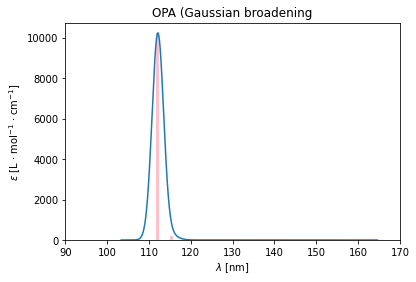

In [114]:
import matplotlib.pyplot as plt
plt.plot(opa_spectrum['convolution']['x'],opa_spectrum['convolution']['y'])
plt.bar(opa_spectrum['sticks']['poles'],opa_spectrum['sticks']['residues'],color="pink")
plt.title('OPA (Gaussian broadening')
plt.xlabel('$\lambda$ [nm]')
plt.xlim(90, 170)
plt.ylabel('$\epsilon$ [L $\cdot$ mol$^{-1}$ $\cdot$ cm$^{-1}$]')
plt.savefig('opa_spectrum.pdf')

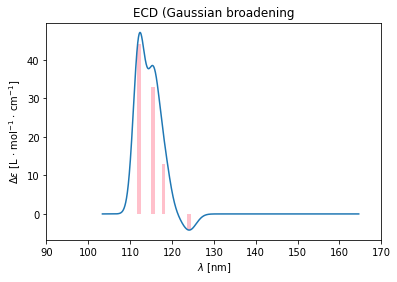

In [117]:
plt.plot(ecd_spectrum['convolution']['x'],ecd_spectrum['convolution']['y'])
plt.bar(ecd_spectrum['sticks']['poles'],ecd_spectrum['sticks']['residues'],color="pink")
plt.title('ECD (Gaussian broadening')
plt.xlabel('$\lambda$ [nm]')
plt.xlim(90, 170)
plt.ylabel('$\Delta\epsilon$ [L $\cdot$ mol$^{-1}$ $\cdot$ cm$^{-1}$]')
plt.savefig('ecd_spectrum.pdf')